In [1]:
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import price_data as price
import statistics
import time
from datetime import date
import os
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport

# Select your transport with a defined url endpoint
transport = AIOHTTPTransport(url="https://saturn.hasura.app/v1/graphql", headers={'x-hasura-admin-secret': 'Rc07SJt4ryC6RyNXDKFRAtFmRkGBbT8Ez3SdaEYsHQoHemCldvs52Kc803oK8X62'})

# Create a GraphQL client using the defined transport
client = Client(transport=transport, fetch_schema_from_transport=True)

async def get_stored_data(symbol,timeframe):
    # Provide a GraphQL query
    split_symbol=symbol.split('/')
    base_currency=split_symbol[0]
    quote_currency=split_symbol[1]
    table=base_currency+quote_currency+'_'+timeframe
    if table=='BTCUSD_1d':
        query = gql(
            """
            query MyQuery {
                BTCUSD_1d {
                    unix
                    close
                    high
                    low
                    open
                }
            }
        """
        )
    elif table=='ETHUSD_1d':
        query = gql(
            """
            query MyQuery {
                ETHUSD_1d {
                    unix
                    close
                    high
                    low
                    open
                }
            }
        """
        )
    elif table=='ETHBTC_1d':
        query = gql(
            """
            query MyQuery {
                ETHBTC_1d {
                    unix
                    close
                    high
                    low
                    open
                }
            }
        """
        )
    else:
        return 'no such table'

    # Execute the query on the transport
    result = await client.execute_async(query)
    candles=result[table]
    df=pd.DataFrame({},columns=['unix','close','high','low','open'])
    for candle in candles:
        df=df.append(candle,ignore_index=True)

    return df.sort_values(by=['unix'], ignore_index=True)

    return result

def find_start(timestamps):
    start_found=False
    timestamps=list(map(lambda x:x[0]/1000,timestamps))
    index=len(timestamps)-1
    while not(start_found):
        print(timestamps[index])
        day=date.fromtimestamp(timestamps[index]).weekday()
        if day==0:
            start_found=True
        else:   
            index=index-1
    return index

def read_data(filename):
    raw=pd.read_csv('data/'+filename)
    timestamps=raw['unix']
    for i in range(len(timestamps)):
        if np.log10(timestamps.iloc[i])<12:
            raw.loc[i,'unix']=timestamps[i]*1000
    return raw.sort_values(by=['unix'], ignore_index=True)

btc_price_data= await get_stored_data('BTC/USD','1d')
btc_price_data

,unix,close,high,low,open
0,1.423440e+12,220.61000,225.00000,215.40,224.22000
1,1.423526e+12,220.96000,223.88000,214.00,220.61000
2,1.423613e+12,219.19000,224.40000,218.10,220.96000
3,1.423699e+12,222.60000,223.20000,217.87,219.19000
4,1.423786e+12,236.00000,241.76000,221.46,222.39000
...,...,...,...,...,...
2344,1.625962e+12,34244.00000,34590.00000,33316.00,33503.00000
2345,1.626048e+12,33078.00000,34655.00000,32600.00,34249.00000
2346,1.626134e+12,32730.00000,33337.00000,32190.00,33077.77262
2347,1.626221e+12,32822.64316,33128.00000,31588.00,32729.00000


In [2]:
weekly_candles=price.get_price_data('1w',data=btc_price_data)
weekly_candles

,unix,open,high,low,close
0,1.423958e+12,224.22000,266.84,214.00,234.14
1,1.424563e+12,234.14000,248.98,228.62,236.59
2,1.425168e+12,236.59000,265.00,232.61,261.15
3,1.425773e+12,262.47000,294.00,259.60,275.23
4,1.426378e+12,275.23000,303.96,275.01,286.12
...,...,...,...,...,...
331,1.624147e+12,38998.89298,41273.00,33411.00,35631.00
332,1.624752e+12,35653.00000,35832.00,29247.00,34744.00
333,1.625357e+12,34743.00000,36600.00,32700.00,35276.00
334,1.625962e+12,35278.00000,35280.00,32063.00,34244.00


In [3]:
def get_sma(data,window, close=True):
     #using daily for now
    timestamps=data['unix'][window-1:]
    if close:
        sma=data.rolling(window).mean()['close'].dropna()
    else:
        sma=data.rolling(window).mean()['open'].dropna()
    return pd.DataFrame({'unix': timestamps,'value':sma})

    # return pd.DataFrame({'unix': list(map(lambda x: x[0], sma)),'value':list(map(lambda x: x[1], sma))})

def get_ema(data,window, close=True):
    timestamps=data['unix'][window:]
    if close:
        ema=data.ewm(span=window,min_periods=window+1, adjust=False).mean()['close'].dropna()
    else:
        ema=data.ewm(span=window,min_periods=window+1, adjust=False).mean()['open'].dropna()
    return pd.DataFrame({'unix': timestamps,'value':ema})

def risk_indicator(fast,slow):
    min_timestamp=max(fast['unix'].min(),slow['unix'].min())

    trimmed_fast=fast.loc[fast['unix']>=min_timestamp]
    slow=slow.loc[slow['unix']>=min_timestamp]
    if len(trimmed_fast)>len(slow): 
        #different values, ie using a daily for fast and weekly for slow
        if (slow['unix'].max()<trimmed_fast['unix'].max()):
            print('true')
            #add another value to the slow moving avarage to facilitate interpolation
            slow=slow.append({'unix': trimmed_fast['unix'].max(), 'value':slow.iloc[-1]['value']},ignore_index=True)
        f=interp1d(slow['unix'],slow['value'])
        slow_interpolated=f(trimmed_fast['unix'])
        slow=pd.DataFrame({'unix':trimmed_fast['unix'],'value':slow_interpolated})

    if ('close' in fast.columns.values.tolist()):
        #using price
        risk_metric=np.divide(trimmed_fast['close'],slow['value'])
    else:
        #using moving average
        risk_metric=np.divide(trimmed_fast['value'],slow['value'])

    mean=np.mean(risk_metric)
    sigma=np.std(risk_metric)
    normalised=(risk_metric-mean)/sigma
    risk=norm.cdf(normalised)
    return pd.DataFrame({'unix':trimmed_fast['unix'],'value':risk})



In [4]:
fast=get_sma(btc_price_data,10)
fast_ema=get_ema(btc_price_data,50)
slow=get_sma(weekly_candles,50)

true


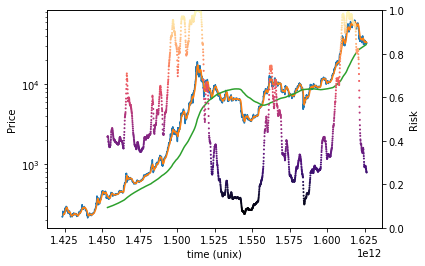

In [5]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('time (unix)')
ax1.set_ylabel('Price')
timestamps=fast['unix']
# ax1.plot(fast['unix'],fast['value'])

risk=risk_indicator(fast,slow)
ax1.plot(btc_price_data['unix'],btc_price_data['close'])
ax1.plot(fast['unix'],fast['value'])
ax1.plot(slow['unix'],slow['value'])
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.set_ylabel('Risk')  
# filtered_risk=risk.loc[risk['value']<0.15]
# ax2.scatter(filtered_risk['unix'],filtered_risk['value'], s=1)
ax2.set_ylim(0,1)
#ax2.vlines(filtered_risk['unix'],0,btc_price_data['close'].max(), colors='r')

ax2.scatter(risk['unix'],risk['value'], s=1, c=risk['value'], cmap='magma')

true


(0.0, 1.0)

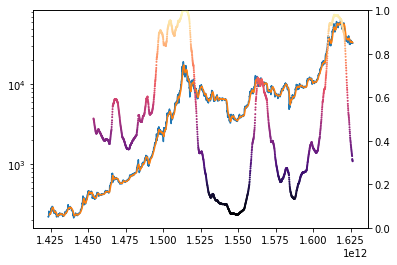

In [6]:

fig2, ax3 = plt.subplots()
ax3.plot(btc_price_data['unix'],btc_price_data['close'])
ax3.plot(fast['unix'],fast['value'])
risk2= risk_indicator(fast_ema,slow)
filtered_risk=risk2.loc[risk2['value']<0.2]
ax3.set_yscale('log')
ax4 = ax3.twinx()
ax4.scatter(risk2['unix'],risk2['value'], s=1, c=risk2['value'], cmap='magma')
ax4.set_ylim(0,1)
# ax4.vlines(filtered_risk['unix'],0,btc_price_data['close'].max(), colors='r')

In [7]:
month_dictionary={
    'Jan':1,
    'Feb':2,
    'Mar':3,
    'Apr':4,
    'May':5,
    'Jun':6,
    'Jul':7,
    'Aug':8,
    'Sep':9,
    'Oct':10,
    'Nov':11,
    'Dec':12,
}

def parse_data(datestring):
    string=datestring.split('-')
    month=month_dictionary[string[0]]
    day=int(string[1])
    year=int(string[2])
    d=date(year,month,day)

    return int(time.mktime(d.timetuple()))
    


In [8]:
def process_coincodex_csv(filename):

    raw_data=pd.read_csv('data/'+filename)
    vectorised_parsing=np.vectorize(parse_data)
    timestamps=vectorised_parsing(raw_data['Date'].values)
    df=raw_data

    df['unix']=timestamps
    df.columns = ['date','open','high','low','close','volume','market cap','unix']
    df.sort_values(by='unix', ignore_index=True, inplace=True)
    df.to_csv('data/'+filename+'_updated')

    return df

In [9]:
def find_intercepts(fast,slow): #each line is a dataframe with time stamp and value, assuming both have same length
    #starting state
    min_timestamp=max(fast['unix'].min(),slow['unix'].min())

    fast=fast.loc[fast['unix']>=min_timestamp]
    slow=slow.loc[slow['unix']>=min_timestamp]

    if len(fast) != len(slow):
        f=interp1d(slow['unix'],slow['value'])
        slow_interpolated=f(fast['unix'])
        slow=pd.DataFrame({'unix':fast['unix'],'value':slow_interpolated})

    timestamps=fast['unix'].values
    line1=fast['value'].values
    line2=slow['value'].values

    line1_above_line2=line1[0]>line2[0] #state
    cross_above=[]
    cross_below=[]
    for i in range(len(line1)):
        if line1_above_line2 and line1[i]<line2[i]:
            cross_below.append(timestamps[i])
        elif not(line1_above_line2) and line1[i]>line2[i]:
            cross_above.append(timestamps[i])
        
        line1_above_line2 = line1[i]>line2[i]

    return {'cross_above': cross_above,'cross_below': cross_below }

In [19]:
eth=await get_stored_data('ETH/USD','1d')

true


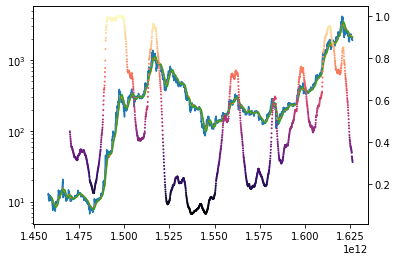

In [30]:
ethereum_weekly=price.get_price_data('1w',data=eth)

fig4, ax7 = plt.subplots()
ema=get_ema(eth,21)
sma=get_sma(eth,20)

eth_fast=get_ema(eth,50)
eth_slow=get_sma(ethereum_weekly,20)
ax7.plot(eth['unix'], eth['close'])
ax7.plot(ema['unix'], ema['value'])
ax7.plot(sma['unix'], sma['value'])
eth_risk=risk_indicator(eth_fast,eth_slow)
#ax7.set_xlim(1600000000,1630000000)
ax8 =ax7.twinx()
ax8.scatter(eth_risk['unix'],eth_risk['value'], s=1, c=eth_risk['value'], cmap='magma')
# ax7.vlines(find_intercepts(ema,sma)['cross_above'],0,eth['close'].max(), colors='r')
# ax7.vlines(find_intercepts(ema,sma)['cross_below'],0,eth['close'].max(), colors='b')
ax7.set_yscale('log')

In [12]:
def ma_channel(data, window):
    timestamps=data['unix']
    sma=data.rolling(window).mean()
    sma['unix']=timestamps
    sma.dropna(inplace=True)    

    return pd.DataFrame({'unix':sma['unix'],'high':sma['high'], 'low':sma['low'], 'value':sma['open']})



In [13]:
def backtest_ma_channel(data,period, slow_ma_gradient):
    print('Datapoints: ',len(data))
    equity=1

    channel=ma_channel(data,period)
    start=channel['unix'].min()
    trimmed_data=channel.loc[channel['unix']>=start]

    state='neutral'
    equity_record=[]
    longs=[]
    shorts=[]
    outcome=[]
    profit=[]
    for i in range(len(channel)):
        upper_bound=channel.iloc[i]['high']
        lower_bound=channel.iloc[i]['low']
        time=channel.iloc[i]['unix']
        
        day=max(list(filter(lambda x: x <= time, slow_ma_gradient.index.values)))
        gradient=slow_ma_gradient.loc[day]
        five_opens=data.loc[data['unix']<=time].tail(n=5)['open'].values # uses opens now as opens are confirmed
        current=five_opens[-1]
        uptrend=gradient>0
        
        if all(opens>upper_bound for opens in five_opens) and state != 'long' and uptrend.all():
            #remember to calculate profit if flipping from short
            if state=='short':
                outcome.append(current<entry)
                profit.append(1-(current/entry))
                equity=equity*(1+(1-(current/entry)))
                # equity=(entry*trade_amount-current*trade_amount)+equity
            state='long'
            entry=current
            longs.append(time)
        elif all(opens<lower_bound for opens in five_opens) and state != 'short' and not(uptrend.all()):
            if state=='long':
                outcome.append(current>entry)
                profit.append(current/entry -1)
                equity=equity*(1+(current/entry -1))
            entry=current
            # trade_amount=equity*entry
            state='short'
            shorts.append(time)
            #print(state+' from $'+str(current))
        if equity < 0:
            equity=0
            print('went broke')
            break
    
    return longs,shorts,np.array(outcome), np.array(profit), equity#pd.DataFrame({'unix':channel['unix'],'equity':equity_record})

def get_gradient(ma):
    
    return pd.Series(
        index=ma['unix'].values,
        data=np.gradient(ma['value'])
    )



# equity_curve=backtest_ma_channel(eth_hourly,20)[2]


In [14]:
eth=read_data('Bitstamp_ETHUSD_d.csv')
eth_hourly=read_data('Bitstamp_ETHUSD_1h.csv')
# eth=price.get_price_data('1d', symbol='ETH/USD')
# eth_hourly=price.get_price_data('1h', symbol='ETH/USD')

In [15]:

# results=[]
# for ema_period in range(1,8):
#     print('ema=', ema_period)
#     ema=get_ema(eth,ema_period, False)
#     ema_gradient=get_gradient(ema)
#     for ma_channel_period in range(24,40):
#         print('ma=', ma_channel_period)
#         longs, shorts, outcome, profit, final_equity=backtest_ma_channel(eth_hourly, ma_channel_period,ema_gradient)
#         print(np.sum(outcome)/len(outcome))
#         print(np.mean(profit))
#         print(final_equity)
#         results.append([ema_period,ma_channel_period,np.sum(outcome)/np.size(outcome),profit, final_equity])

In [16]:
results_df=pd.DataFrame(np.array(results),columns=['ema','channel','success_rate','profit', 'final_equity'])
results_df

NameError: name 'results' is not defined

In [ ]:
filtered=results_df[results_df['final_equity']>30000]
profit_arrays=filtered['profit'].values
win_array=[]
loss_array=[]
max_profit=[]
max_drawdown=[]
number_of_trades=[]
for i in range(len(profit_arrays)):
    array=profit_arrays[i]
    win_filter=array>0
    wins=array[win_filter]
    loss_filter=array<0
    loss=array[loss_filter]
    win_array.append(wins)
    max_profit.append(max(wins))
    loss_array.append(loss)
    max_drawdown.append(min(loss))
    number_of_trades.append(len(array))
    assert len(wins)/(len(array))==filtered.iloc[i]['success_rate']
filtered['wins']=win_array
filtered['losses']=loss_array
filtered['max_profit']=max_profit
filtered['max_drawdown']=max_drawdown
filtered['number_of_trades']=number_of_trades
filtered

<ipython-input-92-14582a801e63>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['wins']=win_array
<ipython-input-92-14582a801e63>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['losses']=loss_array
<ipython-input-92-14582a801e63>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

,ema,channel,success_rate,profit,final_equity,wins,losses,max_profit,max_drawdown,number_of_trades
16,2,24,0.544118,"[-0.00954824414350064, 0.005617004071966969, 0...",49286.914293,"[0.005617004071966969, 0.18586218284680434, 0....","[-0.00954824414350064, -0.026535797713208575, ...",0.669686,-0.123281,272
17,2,25,0.521429,"[-0.012071082013211054, 0.005617004071966969, ...",33982.539398,"[0.005617004071966969, 0.18586218284680434, 0....","[-0.012071082013211054, -0.03456907855525082, ...",0.668626,-0.123281,280
18,2,26,0.514184,"[-0.008548502191736862, 0.005617004071966969, ...",32480.648345,"[0.005617004071966969, 0.18586218284680434, 0....","[-0.008548502191736862, -0.03456907855525082, ...",0.668626,-0.123281,282


In [ ]:
best_result=filtered.iloc[0]
wins=pd.Series(best_result['wins'])
loss=pd.Series(best_result['losses'])
print(wins.describe(),loss.describe())

count    148.000000
mean       0.107237
std        0.134896
min        0.000420
25%        0.022049
50%        0.061550
75%        0.141828
max        0.669686
dtype: float64 count    123.000000
mean      -0.026514
std        0.021631
min       -0.123281
25%       -0.035004
50%       -0.020762
75%       -0.013282
max       -0.000277
dtype: float64


(array([29., 24., 16.,  8., 14.,  8.,  3.,  6.,  7.,  4.,  5.,  6.,  3.,
         0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,
         0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  1.,
         1.]),
 array([4.19865643e-04, 1.71515113e-02, 3.38831569e-02, 5.06148025e-02,
        6.73464481e-02, 8.40780937e-02, 1.00809739e-01, 1.17541385e-01,
        1.34273031e-01, 1.51004676e-01, 1.67736322e-01, 1.84467967e-01,
        2.01199613e-01, 2.17931259e-01, 2.34662904e-01, 2.51394550e-01,
        2.68126196e-01, 2.84857841e-01, 3.01589487e-01, 3.18321132e-01,
        3.35052778e-01, 3.51784424e-01, 3.68516069e-01, 3.85247715e-01,
        4.01979360e-01, 4.18711006e-01, 4.35442652e-01, 4.52174297e-01,
        4.68905943e-01, 4.85637589e-01, 5.02369234e-01, 5.19100880e-01,
        5.35832525e-01, 5.52564171e-01, 5.69295817e-01, 5.86027462e-01,
        6.02759108e-01, 6.19490753e-01, 6.36222399e-01, 6.52954045e-01,
        6.69685690e-01]),
 <BarContainer objec

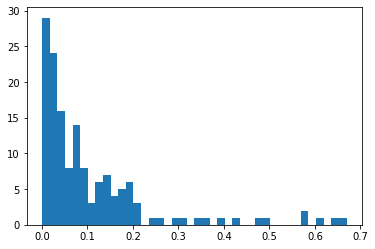

In [ ]:
ema=get_ema(eth,2, False)
gradient=get_gradient(ema)
channel=ma_channel(eth_hourly,26)
longs, shorts, outcome, profit, final_equity=backtest_ma_channel(eth_hourly, 26,gradient)
print('done')


Datapoints:  27787
done


In [ ]:
#testing on recent data
recent_eth_hourly=price.get_price_data('1h', symbol='ETH/USD')
recent_eth_daily=price.get_price_data('1d', symbol='ETH/USD')

results2=[]
# for ema_period in range(10,50):
#     print('ema=', ema_period)
ema=get_ema(recent_eth_daily,2, False)
gradient=get_gradient(ema)
channel=ma_channel(recent_eth_hourly,26)
#     for ma_channel_period in range(10,50):
#         print('ma=', ma_channel_period)
longs, shorts, outcome, profit, final_equity=backtest_ma_channel(recent_eth_hourly, 26,gradient)
#         if len(outcome)==0:
#             print('skipping')
#             break
#         print(np.sum(outcome)/len(outcome))
#         print(np.mean(profit))
#         print(final_equity)

# results2.append([ema_period,ma_channel_period,np.sum(outcome)/np.size(outcome),profit, final_equity])
# results_df2=pd.DataFrame(np.array(results),columns=['ema','channel','success_rate','profit', 'final_equity'])


Datapoints:  1501


In [ ]:
np.sum(outcome)/np.size(outcome),profit, final_equity

In [ ]:
print(np.sum(outcome)/len(outcome))
np.mean(profit)

In [ ]:
def conditional_risk(data,ma_period):
    #identify probability of uptrend and downtrend on moving average
    ma=get_ema()
    #identify P(risk_metric,trend)=P(trend|risk_metric)*P(risk_metric)

    #Risk=P(risk_metric|trend)=P(risk_metric,trend)/P(trend)
    pass

In [ ]:
ethbtc=process_coincodex_csv('ETHBTC_d.csv')
risk=risk_indicator(ethbtc,get_sma(ethbtc,350))
fig1,ax1 = plt.subplots()
ax1.plot(risk['unix'],risk['value'])

NameError: name 'process_coincodex_csv' is not defined

In [ ]:
def update_csv(symbol,timeframe):
    
    split_symbol=symbol.split('/')
    base_currency=split_symbol[0]
    quote_currency=split_symbol[1]
    filename=base_currency+quote_currency+'_'+timeframe+'.csv'
    old_data=pd.read_csv('data/'+filename)
    print(old_data)
    max_timestamp=old_data['unix'].max()

    latest_price_data=price.get_price_data(symbol,interval,since=max_timestamp)

    new_data=latest_price_data[latest_price_data['unix']>=max_timestamp]
    old_data.drop(old_data['unix'].idxmax())

    new_file=old_data.append(new_data,ignore_index=True)

    print(new_file)




